# Let's introduce ourselves to python pandas and financial data

## First let's download some basic financial data

In [62]:
import yfinance as yf
import pandas as pd
import seaborn as sns 
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


sns.set_theme()

# Download daily price data for SPY
spy = yf.download("SPY", start="2015-01-01", end="2025-01-01")
nvd = yf.download("NVDA", start="2015-01-01", end="2025-01-01")

spy.head()

/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_21614/2436705774.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  spy = yf.download("SPY", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed
/var/folders/mc/qf75k40s6ns_nr8c35wdmp400000gn/T/ipykernel_21614/2436705774.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  nvd = yf.download("NVDA", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY
Date,,,,,
2015-01-02,171.093704,172.301356,170.052634,171.884928,121465900
2015-01-05,168.003815,170.210879,167.695662,170.044311,169632600
2015-01-06,166.421326,168.836603,165.621778,168.311900,209151400
2015-01-07,168.495163,168.836637,167.304185,167.753921,125346700
2015-01-08,171.485153,171.701704,169.894407,169.911055,147217800


In [63]:
new_columns = ['close', 'high', 'low', 'open', 'volume']

spy.columns = new_columns


spy.head()

,close,high,low,open,volume
Date,,,,,
2015-01-02,171.093704,172.301356,170.052634,171.884928,121465900
2015-01-05,168.003815,170.210879,167.695662,170.044311,169632600
2015-01-06,166.421326,168.836603,165.621778,168.311900,209151400
2015-01-07,168.495163,168.836637,167.304185,167.753921,125346700
2015-01-08,171.485153,171.701704,169.894407,169.911055,147217800


<Axes: xlabel='Date'>

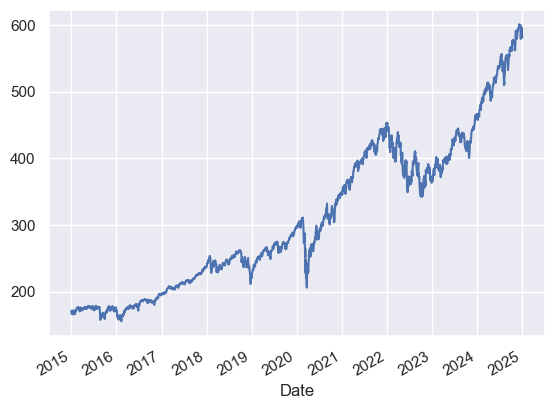

In [64]:
spy['close'].plot()

<Axes: ylabel='Frequency'>

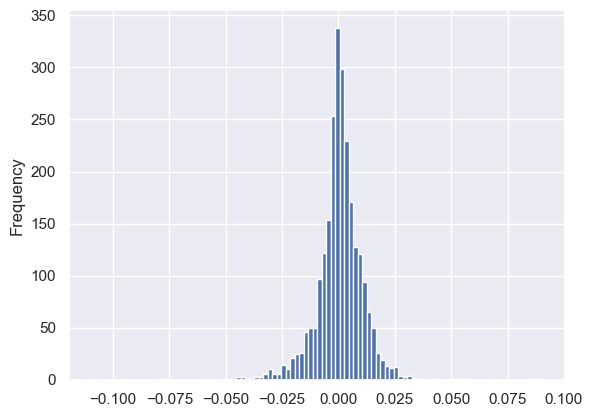

In [65]:
spy.loc[:, 'returns'] = spy['close'].pct_change()

spy['returns'].plot(kind='hist', bins=100)



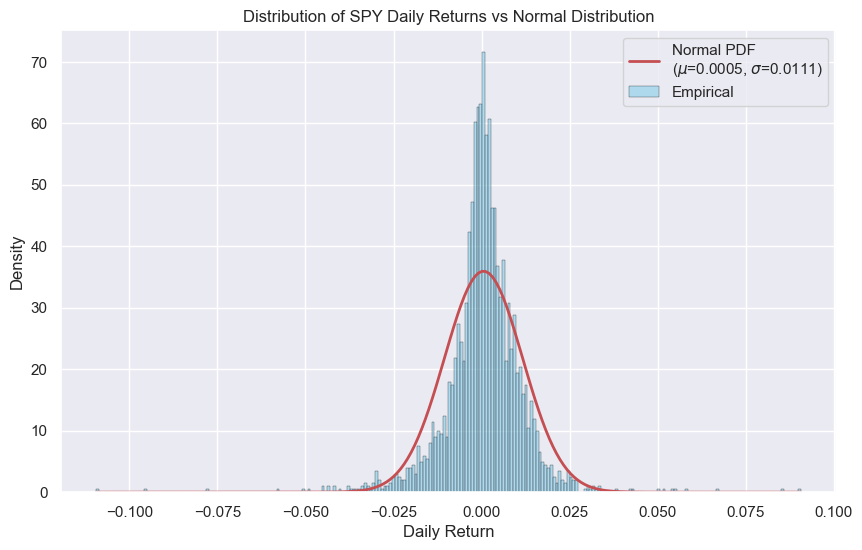

In [66]:
# Drop NA values from returns
returns_spy = spy["returns"].dropna()

# Estimate mean and std of returns
mu_spy, sigma_spy = returns_spy.mean(), returns_spy.std()

# Create a range of values for the normal PDF
x = np.linspace(returns_spy.min(), returns_spy.max(), 200)
pdf_spy = norm.pdf(x, mu_spy, sigma_spy)

# Plot histogram of returns with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(returns_spy, bins=250, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Empirical")

# Plot the normal PDF
plt.plot(x, pdf_spy, 'r-', lw=2, label=f"Normal PDF\n($\\mu$={mu_spy:.4f}, $\\sigma$={sigma_spy:.4f})")

plt.title("Distribution of SPY Daily Returns vs Normal Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.show()


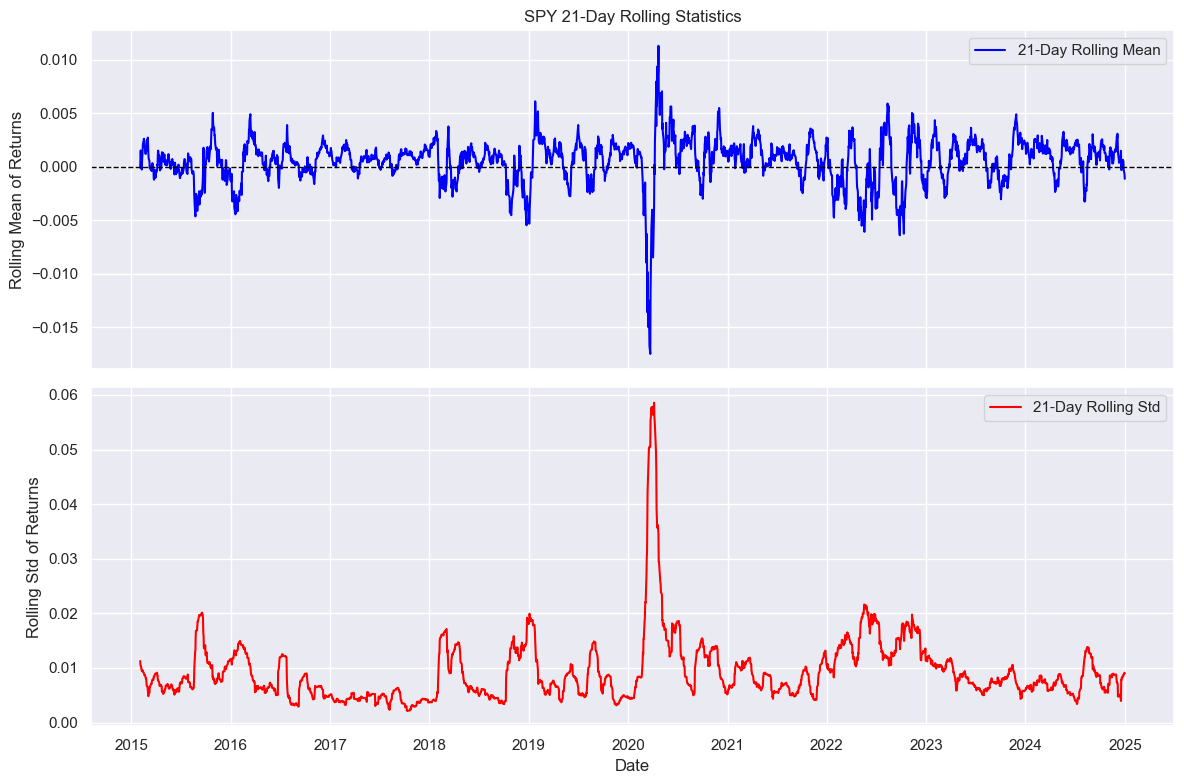

In [67]:
import matplotlib.pyplot as plt

rolling_window = 21  # about one trading month
spy["rolling_mean"] = spy["returns"].rolling(window=rolling_window).mean()
spy["rolling_std"] = spy["returns"].rolling(window=rolling_window).std()

# Create two subplots
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot rolling mean
axes[0].plot(spy.index, spy["rolling_mean"], color="blue", label=f"{rolling_window}-Day Rolling Mean")
axes[0].axhline(0, color="black", linestyle="--", linewidth=1)
axes[0].set_ylabel("Rolling Mean of Returns")
axes[0].set_title(f"SPY {rolling_window}-Day Rolling Statistics")
axes[0].legend()

# Plot rolling std
axes[1].plot(spy.index, spy["rolling_std"], color="red", label=f"{rolling_window}-Day Rolling Std")
axes[1].set_ylabel("Rolling Std of Returns")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()


<Axes: xlabel='Date'>

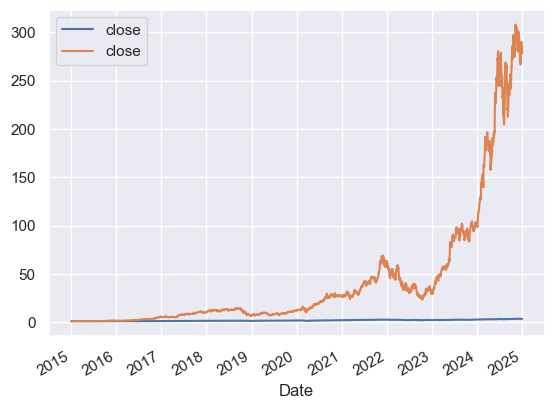

In [68]:
nvd.columns = new_columns



(spy['close']/spy['close'].iloc[0]).plot(legend='SPY')
(nvd['close']/nvd['close'].iloc[0]).plot(legend='Nvidia')

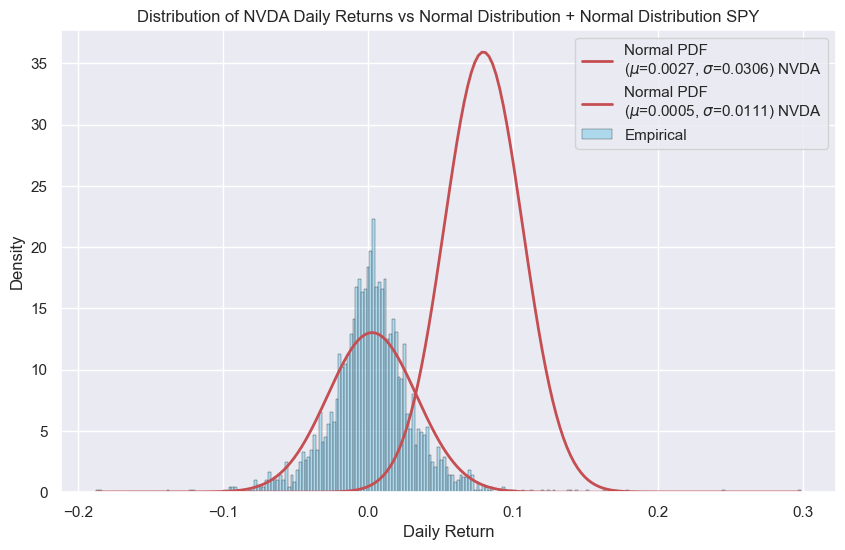

In [69]:
# Drop NA values from returns
nvd.loc[:, 'returns'] = nvd['close'].pct_change()
returns = nvd["returns"].dropna()

# Estimate mean and std of returns
mu_nvd, sigma_nvd = returns.mean(), returns.std()

# Create a range of values for the normal PDF
x = np.linspace(returns.min(), returns.max(), 200)
pdf_nvd = norm.pdf(x, mu_nvd, sigma_nvd)

# Plot histogram of returns with seaborn
plt.figure(figsize=(10, 6))
sns.histplot(returns, bins=250, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Empirical")

# Plot the normal PDF
plt.plot(x, pdf_spy, 'r-', lw=2, label=f"Normal PDF\n($\\mu$={mu_nvd:.4f}, $\\sigma$={sigma_nvd:.4f}) NVDA")
plt.plot(x, pdf_nvd, 'r-', lw=2, label=f"Normal PDF\n($\\mu$={mu_spy:.4f}, $\\sigma$={sigma_spy:.4f}) NVDA")

plt.title("Distribution of NVDA Daily Returns vs Normal Distribution + Normal Distribution SPY")
plt.xlabel("Daily Return")
plt.ylabel("Density")
plt.legend()
plt.show()
